# Большая лабораторная работа

## Актуальный код

Импортируем бибилотеки

In [1]:
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle
from imageio import imread, imsave
import numpy as np
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.filters import gaussian
from skimage.filters import try_all_threshold
from skimage.filters import threshold_otsu, threshold_triangle, rank
from skimage.morphology import binary_closing
from skimage.morphology import binary_opening
from skimage.morphology import disk
from skimage.transform import (hough_line, hough_line_peaks, probabilistic_hough_line)
from skimage.util import img_as_ubyte
import cv2
import os

In [2]:
data_path = "..\\SG_Big_Lab_SPBPU_2020\\Data 1"

Мы предполагаем, что все фотографии находятся именно в указанном каталоге, который не содержит других подпапок или чего-то другого. Все изображения имеют название вида [метка]_[номер].jpg

In [3]:
def find_mark(img_name):
    metka = ''
    if img_name[0:2] == 'no':
        num = int(img_name[3:len(img_name) - 4])
        metka = 'no'
    elif img_name[0:3] == 'yes':
        num = int(img_name[4:len(img_name) - 4])
        metka = 'yes'
    elif img_name[0:5] == 'undef':
        num = int(img_name[6:len(img_name) - 4])
        metka = 'undef'
    else:
        metka = 'null'
    return metka

In [4]:
def crop_image_by_boundary(img, boundary):
    return img[boundary[0] : boundary[1], boundary[2] : boundary[3]]

Возвращает описывающий прямоугольник

In [6]:
def get_boundary(mask):
    horizon_indexes = np.where(np.any(mask, axis=0))[0]
    vertical_indexes = np.where(np.any(mask, axis=1))[0]
    
    left = horizon_indexes[0]
    right = horizon_indexes[-1]
    top = vertical_indexes[0]
    bottom = vertical_indexes[-1]
    
    rect_border = Rectangle((left, top), right - left, bottom - top, linewidth=3, edgecolor='c', facecolor='none')
    return rect_border

Функция ищет совпадения на двух картинках ([большая часть позаимствована здесь (Example 26)](https://www.programcreek.com/python/example/89367/cv2.findHomography))

In [7]:
def find_matches_in_images(img1, img2):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    orb_detector = cv2.ORB_create(5000)

    kpt1, desc1 = orb_detector.detectAndCompute(gray1, None)
    kpt2, desc2 = orb_detector.detectAndCompute(gray2, None)

    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(desc1, desc2)
    matches_length = len(matches)
    points1 = np.zeros((matches_length, 2))
    points2 = np.zeros((matches_length, 2))
    for i in range(matches_length):
        points1[i, :] = kpt1[matches[i].queryIdx].pt
        points2[i, :] = kpt2[matches[i].trainIdx].pt

    homography, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
    
    #fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    #fig.set_dpi(200)
    #fig.suptitle("Looking for matches in the pictures find_matches_in_images")
    #
    #ax[0][0].set_title('What we are looking for')
    #ax[0][0].imshow(gray1, cmap='gray')
    
    #ax[0][1].set_title('Where we are looking')
    #ax[0][1].imshow(gray2, cmap='gray')
    
    #ax[1][0].set_title('What we are looking for')
    #ax[1][0].imshow(gray1, cmap='gray')
    #ax[1][0].plot(points1[:, 0], points1[:, 1], "co")
    
    #ax[1][1].set_title('Where we are looking')
    #ax[1][1].imshow(gray2, cmap='gray')
    #ax[1][1].plot(points2[:, 0], points2[:, 1], "co")
    
    return homography, mask

#### Функция разметки стула

In [8]:
def mark_chair():
    img_name = "undef_04.jpg"
    img = imread("%s\\%s" % (data_path, img_name))
    boundary = [1250, 4000, 650, 2400]
    img_crop = crop_image_by_boundary(img, boundary)
    
    #fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    #fig.set_dpi(200)  
    #fig.suptitle("Crop Chair Image %s" % img_name)
    #ax[0].set_title('Image of the chair')
    #ax[0].imshow(img)
    #ax[1].set_title('Crop Image of the chair')
    #ax[1].imshow(img_crop)
    
    return img_crop

#### Функция разметки двери

In [9]:
def mark_door():
    img_name = "undef_02.jpg"
    img = imread("%s\\%s" % (data_path, img_name))
    boundary = [25, 3900, 400, 2200]
    img_crop = crop_image_by_boundary(img, boundary)
    
    #fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    #fig.set_dpi(200)  
    #fig.suptitle("Crop Door Image %s" % img_name)
    #ax[0].set_title('Image of the door')
    #ax[0].imshow(img)
    #ax[1].set_title('Crop Image of the door')
    #ax[1].imshow(img_crop)
    
    return img_crop

#### Функции работы с изображением

Выделяем объект

In [10]:
def select_object(img, tmp_img):
    homography, mask = find_matches_in_images(tmp_img, img)
    
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    tmp_img_gray = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2GRAY)
    
    tmp_white = np.ones(tmp_img.shape)
    height, width = img_gray.shape
    
    tmp_mask = cv2.warpPerspective(tmp_white, homography, (width, height))
    tmp_new_img = cv2.warpPerspective(tmp_img, homography, (width, height))
    
    #fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    #fig.set_dpi(200)  
    #fig.suptitle("Find matches 'select_object'")
    #ax[0].set_title('What')
    #ax[0].imshow(tmp_img_gray, cmap='gray')
    #ax[0].add_patch(get_boundary(tmp_white))
    #ax[1].set_title('Where')
    #ax[1].imshow(img_gray, cmap='gray')
    #ax[1].add_patch(get_boundary(tmp_mask))
    
    return tmp_mask, tmp_new_img

Убираем перспективу

In [11]:
def remove_perspective(img, chair_img, door_img):
    chair_mask, chair_tmp = select_object(img, chair_img)
    door_mask, door_tmp = select_object(img, door_img)

    homography, mask = find_matches_in_images(door_tmp, door_img)
    height, width = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).shape
    
    general_img = cv2.warpPerspective(img, homography, (width, height))
    general_door_mask = cv2.warpPerspective(door_mask, homography, (width, height))
    general_chair_mask = cv2.warpPerspective(chair_mask, homography, (width, height))

    return general_img, general_door_mask, general_chair_mask

In [12]:
def get_images_list(path):
    folder = []
    for i in os.walk(data_path):
        folder.append(i)
    images_list = folder[0][2]
    return images_list

### Основная работа

Process image no_01.jpg


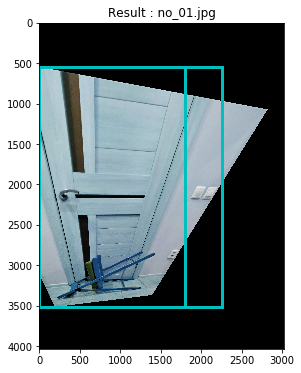

No  : no_01.jpg
Process image no_02.jpg


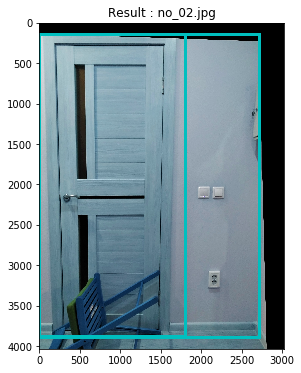

No  : no_02.jpg
Process image no_06.jpg


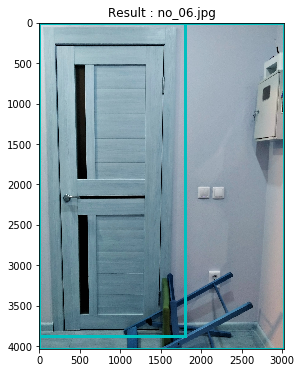

No  : no_06.jpg
Process image undef_02.jpg


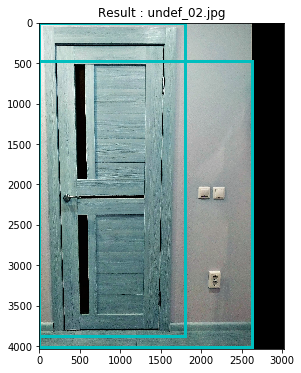

No  : undef_02.jpg
Process image undef_04.jpg


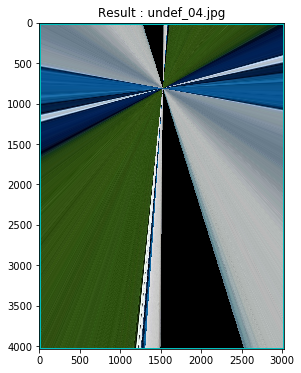

No  : undef_04.jpg
Process image yes_01.jpg


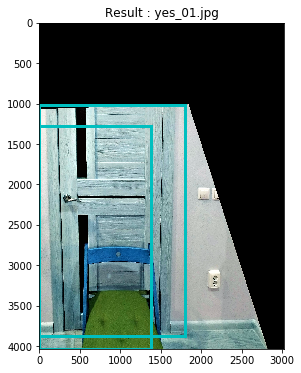

Yes : yes_01.jpg
Process image yes_02.jpg


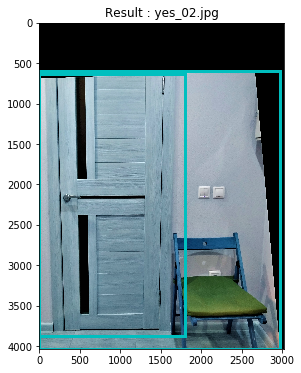

No  : yes_02.jpg
Process image yes_03.jpg


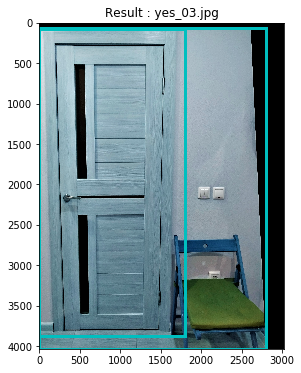

No  : yes_03.jpg
Process image yes_04.jpg


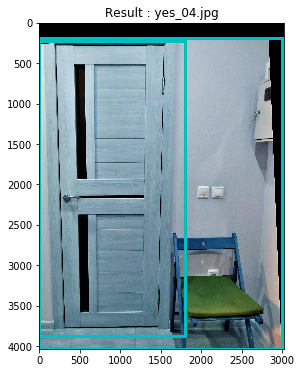

No  : yes_04.jpg
Process image yes_06.jpg


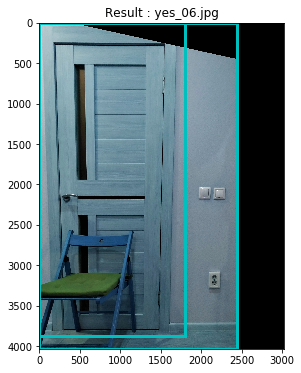

No  : yes_06.jpg
-------------------------------
Total number: 10
The number of correctly defined: 4
Percentage of accuracy: 40.0000


In [13]:
chair_tmp = mark_chair()
door_tmp = mark_door()
door_tmp_gray = cv2.cvtColor(door_tmp, cv2.COLOR_BGR2GRAY)
chair_tmp_gray = cv2.cvtColor(chair_tmp, cv2.COLOR_BGR2GRAY)

img_dataset_name = get_images_list(data_path)
metka_yes = 'yes'
metka_no = 'no'
metka_undef = 'undef'
num_total = 0
num_correct = 0
for name in img_dataset_name:
    print("Process image %s" % name)
    num_total = num_total + 1
    img = cv2.imread("%s\\%s" % (data_path, name))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    non_perspective_img, non_perspective_door_mask, non_perspective_chair_mask = remove_perspective(img, chair_tmp, door_tmp)

    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    ax.set_title("Result : %s" % name)

    ax.imshow(non_perspective_img, cmap='gray')
    chair_non_perspective_border = get_boundary(non_perspective_chair_mask)
    ax.add_patch(chair_non_perspective_border)
    door_non_perspective_border = get_boundary(non_perspective_door_mask)
    ax.add_patch(door_non_perspective_border)
    plt.show()
    metka = find_mark(name)
    if (door_non_perspective_border.get_width() > chair_non_perspective_border.get_width()):
        if metka == metka_yes:
            num_correct = num_correct + 1
        print("Yes : %s" % name) 
    else:
        if metka == metka_no:
            num_correct = num_correct + 1
        print("No  : %s" % name)
        
print("-------------------------------")
print("Total number: %i" % num_total)
print("The number of correctly defined: %i" % num_correct)
print("Percentage of accuracy: %.4f" % (num_correct / num_total * 100))

Пока мне кажется, что достигнуто очень мало результатов и результаты алгоритма близки к рандомным. Датасет довольно сложный, т.к. стул близок по цвету к двери и имеет много тонких линий, которые сливаются с тенями на двери. В дальнейшем мне хочется пересмотреть алгоритм. Прибегнуть к использованию преобразования Хафа для нахождения прямых двери на изображении, добавить несколько шаблонов для распознавания стула на изображении. Также хотелось бы корректно распознавать, если на изображении вообще нет стула или двери.